In [135]:
from pathlib import Path
import warnings
import os

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.attacks.utils import get_dfs_for_victim_and_adv
from distribution_inference.attacks.whitebox.utils import get_attack, wrap_into_loader
from distribution_inference.attacks.whitebox.affinity.utils import get_loader_for_seed_data
from distribution_inference.config import DatasetConfig, AttackConfig, WhiteBoxAttackConfig, TrainConfig
from distribution_inference.utils import flash_utils, warning_string
from distribution_inference.logging.core import AttackResult
load_config = Path("./cel_AMC_interp.json")
meta_path = "/p/adversarialml/as9rw/tmp/celeba/Male"

In [136]:
attack_config: AttackConfig = AttackConfig.load(
        load_config, drop_extra_fields=False)
wb_attack_config: WhiteBoxAttackConfig = attack_config.white_box
train_config: TrainConfig = attack_config.train_config
data_config: DatasetConfig = train_config.data_config
if train_config.misc_config is not None:
        # TODO: Figure out best place to have this logic in the module
    if train_config.misc_config.adv_config:
            # Scale epsilon by 255 if requested
        if train_config.misc_config.adv_config.scale_by_255:
            train_config.misc_config.adv_config.epsilon /= 255
if len(attack_config.values) != 1:
        warnings.warn(warning_string(
            "\nTesting one meta-classifier against multiple ratios.\n"))
values_to_test = [str(x) for x in attack_config.values]
folders = os.listdir(meta_path)
for value in values_to_test:
    if value not in folders:
        raise ValueError(
            f"No model found for value {value} in {meta_path}")
#flash_utils(attack_config)
ds_wrapper_class = get_dataset_wrapper(data_config.name)

    # Get dataset info object
ds_info = get_dataset_information(data_config.name)()

    # Create new DS object for both and victim
_, data_config_vic_1 = get_dfs_for_victim_and_adv(
        data_config)
ds_vic_1 = ds_wrapper_class(data_config_vic_1, skip_data=True)

In [177]:
models_vic_1 = ds_vic_1.get_models(
            train_config,
            n_models=attack_config.num_victim_models,
            on_cpu=attack_config.on_cpu,
            shuffle=False,
            model_arch=attack_config.victim_model_arch,
            custom_models_path=None,)

        # For each value (of property) asked to experiment with
for i, prop_value in enumerate([attack_config.values[2]]):
            # Creata a copy of the data config, with the property value
            # changed to the current value
    _, data_config_vic_2 = get_dfs_for_victim_and_adv(
                data_config, prop_value=prop_value)

            # Create new DS object for both and victim (for other ratio)
    ds_vic_2 = ds_wrapper_class(data_config_vic_2, skip_data=True)

            # Load victim's model for other value
    models_vic_2 = ds_vic_2.get_models(
                train_config,
                n_models=attack_config.num_victim_models,
                on_cpu=attack_config.on_cpu,
                shuffle=False,
                model_arch=attack_config.victim_model_arch,
                custom_models_path=None)

            # Generate test set
    test_data = wrap_into_loader(
                [models_vic_1, models_vic_2],
                batch_size=wb_attack_config.batch_size,
                shuffle=False,
                wrap_with_loader=False
            )

            # Look at all models
    attack_model_path_dir = os.path.join(
                meta_path, str(prop_value))
    for attack_model_path in [os.listdir(attack_model_path_dir)[1]]:
                # Skip if directory
        if os.path.isdir(os.path.join(attack_model_path_dir, attack_model_path)):
                    continue

                # Create attacker object
        attacker_obj = get_attack(wb_attack_config.attack)(
                    None, wb_attack_config)

                # Load model
        attacker_obj.load_model(os.path.join(
                    attack_model_path_dir, attack_model_path))
        
                # Make seed-data loader for this attack
        seed_data_loader = get_loader_for_seed_data(
                    attacker_obj.seed_data_ds, wb_attack_config)
                # Create affinity features
        features_test = attacker_obj.make_affinity_features(
                    test_data[0], seed_data_loader)


Available models: 500


Loading models: 100%|██████████| 500/500 [00:07<00:00, 62.64it/s]


Available models: 500


Loading models:  12%|█▏        | 58/500 [00:17<02:35,  2.85it/s]

In [ ]:
import torch.nn as nn
class Wrapper(nn.Module):
    def __init__(self,amc):
        super().__init__()
        self.amc=amc
    def forward(self, *args):
        # Wrap args into one list
        return self.amc(args)

w = Wrapper(attacker_obj.model)

In [ ]:
from captum.attr import IntegratedGradients
import torch as ch
           
def collate_fn(data):
    features, labels = zip(*data)
    # Combine them per-layer
    x = [[] for _ in range(len(features[0]))]
    for feature in features:
        for i, layer_feature in enumerate(feature):
            x[i].append(layer_feature)

    x = [ch.stack(x_, 0) for x_ in x]
    y = ch.tensor(labels).float()

    return x, y

class BasicDataset(ch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create laoaders out of all the given data
def get_loader(data, shuffle):
    ds = BasicDataset(data[0], data[1])
    return ch.utils.data.DataLoader(
        ds, batch_size=wb_attack_config.batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle)
test_loader_ = get_loader((features_test, test_data[1]), False)
data = next(iter(test_loader_))[0]
data = [x.cuda().requires_grad_() for x in data]
ig = IntegratedGradients(w)
test_input_tensor = data
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute((*test_input_tensor,),target=0, return_convergence_delta=True)
#attr = attr.cpu().detach().numpy()
attr = [x.cpu().detach().numpy() for x in attr]

Average Feature Importances
2668 :  -0.119
2625 :  -0.112
2614 :  -0.109
2647 :  -0.106
2664 :  -0.100
2621 :  -0.097
2822 :  -0.064
14 :  0.061
2649 :  0.060
2611 :  0.060
3000 :  0.059
76 :  0.057
2637 :  0.057
2604 :  0.055
2628 :  0.055
2634 :  0.054
2658 :  0.053
3763 :  -0.052
2180 :  0.052
2661 :  0.051
55 :  0.049
31 :  0.049
61 :  0.049
701 :  0.048
4339 :  -0.047
88 :  0.047
4094 :  -0.046
3833 :  -0.046
4341 :  -0.045
2199 :  -0.045
214 :  -0.045
85 :  0.045
1853 :  -0.044
1858 :  -0.042
1855 :  -0.042
3758 :  -0.042
3760 :  -0.042
3020 :  0.041
83 :  0.041
244 :  -0.041
4011 :  -0.041
1312 :  -0.040
3144 :  -0.040
3010 :  0.040
3373 :  0.039
3732 :  -0.038
3730 :  -0.038
2703 :  -0.038
2689 :  -0.038
4342 :  -0.038
4320 :  -0.037
879 :  0.034
1856 :  -0.034
3751 :  -0.034
3739 :  -0.034
3260 :  0.032
775 :  -0.031
1834 :  -0.031
3858 :  -0.031
4072 :  -0.029
983 :  -0.028
2938 :  -0.028
3955 :  -0.027
727 :  0.026
3658 :  -0.026
1846 :  -0.026
908 :  0.026
4609 :  -0.025
12

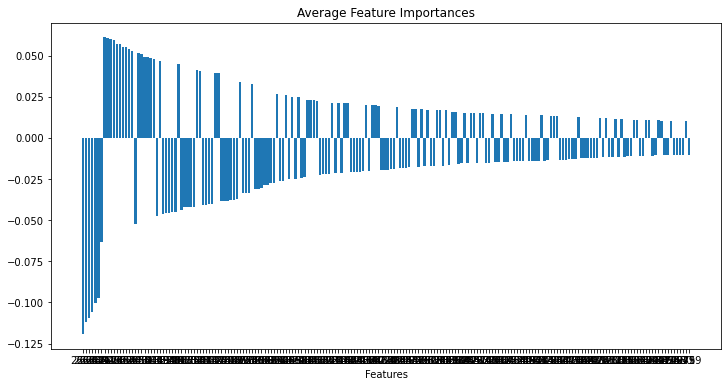

In [ ]:
attr = attr[:4]
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
#plt.figure(dpi=1200)
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
means = np.mean(np.mean(attr,axis=0), axis=0)
ind = np.argsort(np.absolute(means))[::-1][:int(0.2*len(means))]
visualize_importances(attacker_obj.retained_pairs[ind], means[ind])

In [ ]:
print(len(ind))
def reverse_ind(x,leng):
#get the indexes of points from the index of pairs, x. leng is # of points
    indices_i, indices_j = [], []
    f = np.arange(leng)
    for j in f[:-1]:
        others = f[j+1:]
        indices_i += [j] * len(others)
        indices_j += list(range(j+1, leng))
    indices_i = np.array(indices_i)
    indices_j = np.array(indices_j)
    return (indices_i[x],indices_j[x])


198


In [ ]:
from distribution_inference.attacks.blackbox.core import sigmoid

p_ind = reverse_ind(attacker_obj.retained_pairs[ind],len(attacker_obj.seed_data_ds))
"""
pis = attacker_obj.seed_data_ds[p_ind[0]].cuda()
pjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()

pred_i = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))
pred_j = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))
"""

'\npis = attacker_obj.seed_data_ds[p_ind[0]].cuda()\npjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()\n\npred_i = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))\npred_j = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))\n'

83
(500, 83, 1)


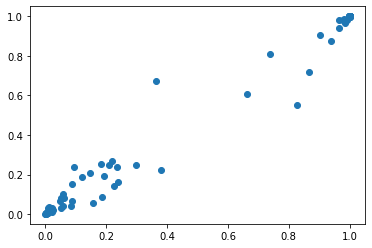

In [ ]:
uni_p = np.unique(np.concatenate(p_ind))
ps = attacker_obj.seed_data_ds[uni_p].cuda()
preds = [sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(ps).cpu().detach().numpy() for m in models_vic_2]))]
print(len(uni_p))
print(preds[0].shape)
preds = [np.mean(x,0) for x in preds]
plt.scatter(preds[0],preds[1])


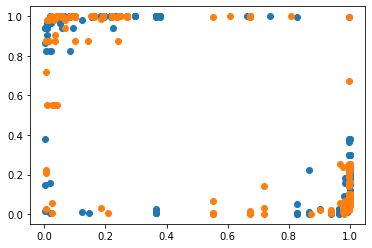

In [ ]:
pis = attacker_obj.seed_data_ds[p_ind[0]].cuda()
pjs = attacker_obj.seed_data_ds[p_ind[1]].cuda()

pred_i = (sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pis).cpu().detach().numpy() for m in models_vic_2])))
pred_j = (sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_1])),sigmoid(np.array([m.cuda().eval()(pjs).cpu().detach().numpy() for m in models_vic_2])))
pred_i = [np.mean(x,0) for x in pred_i]
pred_j = [np.mean(x,0) for x in pred_j]
plt.scatter(pred_i[0],pred_j[0])
plt.scatter(pred_i[1],pred_j[1])


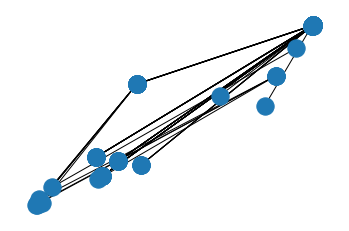

In [ ]:
import networkx  as nx
G=nx.Graph()
for i in range(50):
    G.add_node(i,pos=(pred_i[0][i][0],pred_i[1][i][0]))
    G.add_node(100-i,pos=(pred_j[0][i][0],pred_j[1][i][0]))
for i in range(50):
    G.add_edge(i,100-i)
pos=nx.get_node_attributes(G,'pos')
fig, ax = plt.subplots()
#nx.draw_networkx_nodes(G,pos, ax=ax)
#...



nx.draw(G,pos,ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

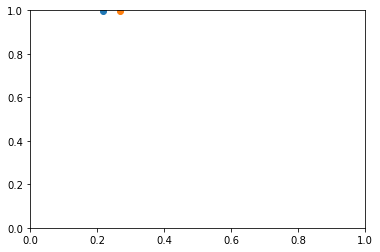

In [ ]:
n=20
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(pred_i[0][n],pred_j[0][n])
plt.scatter(pred_i[1][n],pred_j[1][n])